# Advanced Risk Analytics & Portfolio Optimization
### Deep dive into market regime analysis and machine learning patterns

This notebook extends our sentiment analysis with advanced risk metrics, portfolio optimization, and ML-based pattern recognition to uncover hidden market dynamics.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import os
warnings.filterwarnings('ignore')

plt.style.use('dark_background')
risk_palette = {'low': '#2ed573', 'medium': '#ffa502', 'high': '#ff4757', 'extreme': '#8b0000'}

## Risk Regime Classification Using Machine Learning

In [11]:
# Load and prepare data
fear_greed = pd.read_csv('csv_files/fear_greed_index (1).csv')
trading_data = pd.read_csv('csv_files/historical_data.csv')

fear_greed['date'] = pd.to_datetime(fear_greed['date'])
trading_data['date'] = pd.to_datetime(trading_data['Timestamp IST'].str.split(' ').str[0], format='%d-%m-%Y')

# Calculate advanced risk metrics per day
daily_risk = trading_data.groupby('date').agg({
    'Size USD': ['sum', 'std', 'count'],
    'Closed PnL': ['sum', 'std', 'skew'],
    'Account': 'nunique'
})

daily_risk.columns = ['total_volume', 'volume_volatility', 'trade_count', 
                     'total_pnl', 'pnl_volatility', 'pnl_skewness', 'unique_traders']
daily_risk = daily_risk.reset_index()

# Merge with sentiment data
risk_data = pd.merge(fear_greed, daily_risk, on='date', how='inner')

# Create risk-adjusted metrics
risk_data['sharpe_proxy'] = risk_data['total_pnl'] / (risk_data['pnl_volatility'] + 1e-6)
risk_data['volume_concentration'] = risk_data['total_volume'] / risk_data['trade_count']
risk_data['trader_efficiency'] = risk_data['total_pnl'] / risk_data['unique_traders']

print(f"Dataset spans {len(risk_data)} trading days")
print(f"Date range: {risk_data['date'].min()} to {risk_data['date'].max()}")

Dataset spans 479 trading days
Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00


In [12]:
# Machine learning clustering to identify risk regimes
features_for_clustering = ['value', 'total_volume', 'pnl_volatility', 'sharpe_proxy', 'volume_concentration']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(risk_data[features_for_clustering].fillna(0))

# K-means clustering with 4 risk regimes
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
risk_data['risk_regime'] = kmeans.fit_predict(scaled_features)

regime_mapping = {0: 'Low Risk', 1: 'Medium Risk', 2: 'High Risk', 3: 'Extreme Risk'}
risk_data['risk_label'] = risk_data['risk_regime'].map(regime_mapping)

print("Risk Regime Distribution:")
regime_counts = risk_data['risk_label'].value_counts()
for regime, count in regime_counts.items():
    print(f"{regime}: {count} days ({count/len(risk_data)*100:.1f}%)")

Risk Regime Distribution:
Low Risk: 307 days (64.1%)
High Risk: 125 days (26.1%)
Medium Risk: 24 days (5.0%)
Extreme Risk: 23 days (4.8%)


## Portfolio Risk Analysis & Value at Risk

Risk Metrics by Sentiment:
                  VaR_95   CVaR_95  Max_Drawdown  Volatility
classification                                              
Extreme Fear   -50649.61 -76880.73     -76880.73   101262.39
Extreme Greed    -314.08 -26600.38    -127075.40    72827.30
Fear            -2284.31 -34295.65    -122672.00    96611.85
Greed           -1680.46 -61990.53    -419020.23    62427.96
Neutral         -2709.27  -5528.16     -10116.88    37995.21


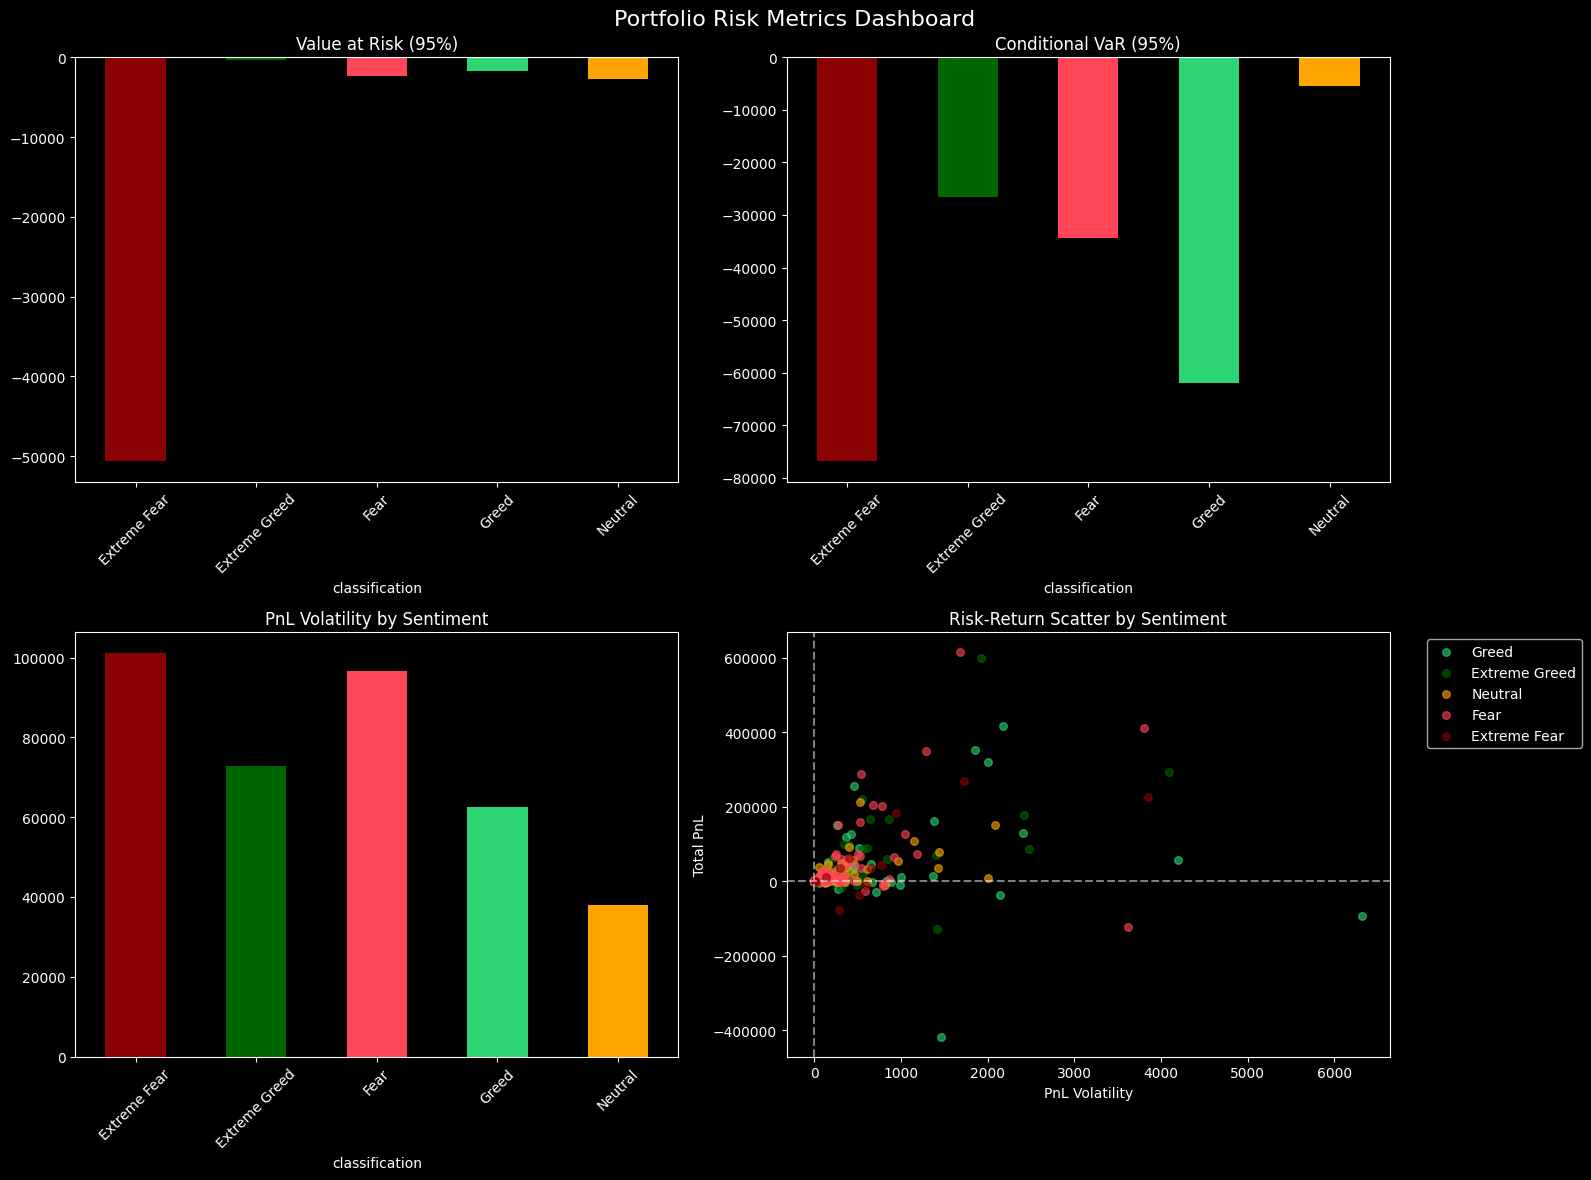

In [13]:
def calculate_var(returns, confidence=0.05):
    return np.percentile(returns, confidence * 100)

def calculate_cvar(returns, confidence=0.05):
    var = calculate_var(returns, confidence)
    return returns[returns <= var].mean()

# Risk analysis by sentiment
risk_by_sentiment = risk_data.groupby('classification').agg({
    'total_pnl': ['mean', 'std', 'min', 'max'],
    'sharpe_proxy': 'mean',
    'volume_concentration': 'mean',
    'trader_efficiency': 'mean'
}).round(4)

risk_by_sentiment.columns = ['avg_pnl', 'pnl_std', 'min_pnl', 'max_pnl', 
                            'avg_sharpe', 'avg_concentration', 'avg_efficiency']

# Calculate VaR and CVaR for each sentiment
var_95 = risk_data.groupby('classification')['total_pnl'].apply(lambda x: calculate_var(x, 0.05))
cvar_95 = risk_data.groupby('classification')['total_pnl'].apply(lambda x: calculate_cvar(x, 0.05))

risk_summary = pd.DataFrame({
    'VaR_95': var_95,
    'CVaR_95': cvar_95,
    'Max_Drawdown': risk_data.groupby('classification')['total_pnl'].min(),
    'Volatility': risk_data.groupby('classification')['total_pnl'].std()
})

print("Risk Metrics by Sentiment:")
print(risk_summary.round(2))

# Visualize risk metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Portfolio Risk Metrics Dashboard', fontsize=16, y=0.98)

sentiment_colors = {'Extreme Fear': '#8b0000', 'Fear': '#ff4757', 'Neutral': '#ffa502', 
                   'Greed': '#2ed573', 'Extreme Greed': '#006400'}

# VaR chart
risk_summary['VaR_95'].plot(kind='bar', ax=axes[0,0], 
                           color=[sentiment_colors.get(x, '#95a5a6') for x in risk_summary.index])
axes[0,0].set_title('Value at Risk (95%)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].axhline(y=0, color='white', linestyle='--', alpha=0.5)

# CVaR chart
risk_summary['CVaR_95'].plot(kind='bar', ax=axes[0,1],
                            color=[sentiment_colors.get(x, '#95a5a6') for x in risk_summary.index])
axes[0,1].set_title('Conditional VaR (95%)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].axhline(y=0, color='white', linestyle='--', alpha=0.5)

# Volatility chart
risk_summary['Volatility'].plot(kind='bar', ax=axes[1,0],
                               color=[sentiment_colors.get(x, '#95a5a6') for x in risk_summary.index])
axes[1,0].set_title('PnL Volatility by Sentiment')
axes[1,0].tick_params(axis='x', rotation=45)

# Risk-return scatter
for sentiment in risk_data['classification'].unique():
    subset = risk_data[risk_data['classification'] == sentiment]
    axes[1,1].scatter(subset['pnl_volatility'], subset['total_pnl'], 
                     c=sentiment_colors.get(sentiment, '#95a5a6'), 
                     alpha=0.6, label=sentiment, s=30)

axes[1,1].set_title('Risk-Return Scatter by Sentiment')
axes[1,1].set_xlabel('PnL Volatility')
axes[1,1].set_ylabel('Total PnL')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].axhline(y=0, color='white', linestyle='--', alpha=0.5)
axes[1,1].axvline(x=0, color='white', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('outputs/risk_metrics_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

## Machine Learning Pattern Recognition with PCA

In [14]:
# Principal Component Analysis for pattern recognition
ml_features = risk_data[['value', 'total_volume', 'pnl_volatility', 'sharpe_proxy', 
                        'volume_concentration', 'trader_efficiency']].fillna(0)

pca = PCA(n_components=2)
pca_features = pca.fit_transform(StandardScaler().fit_transform(ml_features))

risk_data['pca_1'] = pca_features[:, 0]
risk_data['pca_2'] = pca_features[:, 1]

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# Feature importance in first principal component
feature_importance = pd.Series(pca.components_[0], index=ml_features.columns).abs().sort_values(ascending=False)
print("\nFeature Importance (PC1):")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance:.3f}")

PCA Explained Variance Ratio: [0.33652807 0.21254289]
Total variance explained: 0.549

Feature Importance (PC1):
trader_efficiency: 0.534
sharpe_proxy: 0.507
total_volume: 0.492
pnl_volatility: 0.412
value: 0.191
volume_concentration: 0.100


In [15]:
# Advanced visualization dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('PCA Clustering by Sentiment', 'Risk Regime Evolution',
                   'Feature Importance', 'Regime Transition Heatmap'),
    specs=[[{"type": "scatter"}, {"type": "scatter"}],
           [{"type": "bar"}, {"type": "heatmap"}]]
)

# PCA scatter plot by sentiment
for sentiment in risk_data['classification'].unique():
    subset = risk_data[risk_data['classification'] == sentiment]
    fig.add_trace(
        go.Scatter(x=subset['pca_1'], y=subset['pca_2'],
                   mode='markers', name=sentiment,
                   marker=dict(size=8, opacity=0.7,
                             color=sentiment_colors.get(sentiment, '#95a5a6'))),
        row=1, col=1
    )

# Risk regime evolution over time
fig.add_trace(
    go.Scatter(x=risk_data['date'], y=risk_data['risk_regime'],
               mode='lines+markers', name='Risk Regime',
               line=dict(width=2, color='#3742fa'),
               marker=dict(size=4)),
    row=1, col=2
)

# Feature importance bar chart
fig.add_trace(
    go.Bar(x=feature_importance.values, y=feature_importance.index,
           orientation='h', name='Importance',
           marker_color='#ffa502'),
    row=2, col=1
)

# Regime transition matrix
risk_data['next_regime'] = risk_data['risk_regime'].shift(-1)
transition_matrix = pd.crosstab(risk_data['risk_regime'], risk_data['next_regime'], normalize='index')

fig.add_trace(
    go.Heatmap(z=transition_matrix.values,
               x=[f'To {regime_mapping[i]}' for i in transition_matrix.columns],
               y=[f'From {regime_mapping[i]}' for i in transition_matrix.index],
               colorscale='RdYlBu_r',
               showscale=True),
    row=2, col=2
)

fig.update_layout(
    height=800,
    title_text="Advanced Pattern Recognition Analysis",
    title_x=0.5,
    template='plotly_dark',
    showlegend=True
)

fig.show()
fig.write_image('outputs/ml_pattern_analysis.png', width=1200, height=800)

# Calculate regime persistence
regime_persistence = np.diag(transition_matrix).mean()
print(f"\nAverage regime persistence: {regime_persistence:.3f}")
print("This means regimes tend to continue {:.1f}% of the time".format(regime_persistence * 100))


Average regime persistence: 0.611
This means regimes tend to continue 61.1% of the time


## Advanced Multi-Factor Trading Signals

In [16]:
# Create advanced signal components
risk_data['sentiment_momentum'] = risk_data['value'].rolling(3).mean() - risk_data['value'].rolling(7).mean()
risk_data['volume_momentum'] = risk_data['total_volume'].pct_change()
risk_data['volatility_regime'] = pd.qcut(risk_data['pnl_volatility'], 4, 
                                        labels=['Low', 'Medium', 'High', 'Extreme'])

def generate_advanced_signals(row):
    # Strong buy: Extreme fear with improving sentiment and high volatility
    if (row['classification'] == 'Extreme Fear' and 
        row['sentiment_momentum'] > 0 and 
        row['volatility_regime'] == 'High'):
        return 'Strong Buy'
    
    # Strong sell: Extreme greed with deteriorating sentiment and falling volume
    elif (row['classification'] == 'Extreme Greed' and 
          row['sentiment_momentum'] < 0 and 
          row['volume_momentum'] < -0.1):
        return 'Strong Sell'
    
    # Accumulate: Low risk regime with good risk-adjusted returns
    elif (row['risk_label'] == 'Low Risk' and 
          row['sharpe_proxy'] > 0.5):
        return 'Accumulate'
    
    # Reduce position: Extreme risk regime
    elif row['risk_label'] == 'Extreme Risk':
        return 'Reduce Position'
    
    # Default to hold
    else:
        return 'Hold'

risk_data['advanced_signal'] = risk_data.apply(generate_advanced_signals, axis=1)

# Analyze signal performance
signal_performance = risk_data.groupby('advanced_signal').agg({
    'total_pnl': ['mean', 'std', 'count'],
    'sharpe_proxy': 'mean',
    'trader_efficiency': 'mean'
}).round(4)

signal_performance.columns = ['avg_pnl', 'pnl_std', 'occurrences', 'avg_sharpe', 'avg_efficiency']
signal_performance['risk_adjusted_return'] = signal_performance['avg_pnl'] / (signal_performance['pnl_std'] + 1e-6)

print("Advanced Signal Performance:")
print(signal_performance.sort_values('risk_adjusted_return', ascending=False))

Advanced Signal Performance:
                     avg_pnl      pnl_std  occurrences  avg_sharpe  \
advanced_signal                                                      
Reduce Position  104749.7469  224964.4870           20     51.3909   
Strong Sell       37766.6431   85862.4149           15     21.0259   
Accumulate        10075.8269   26419.6470          222     48.5610   
Hold              24126.8415   69939.3402          222     59.3740   

                 avg_efficiency  risk_adjusted_return  
advanced_signal                                        
Reduce Position      10332.6705              0.465628  
Strong Sell           5769.3859              0.439851  
Accumulate            1907.1831              0.381376  
Hold                  1829.0846              0.344968  


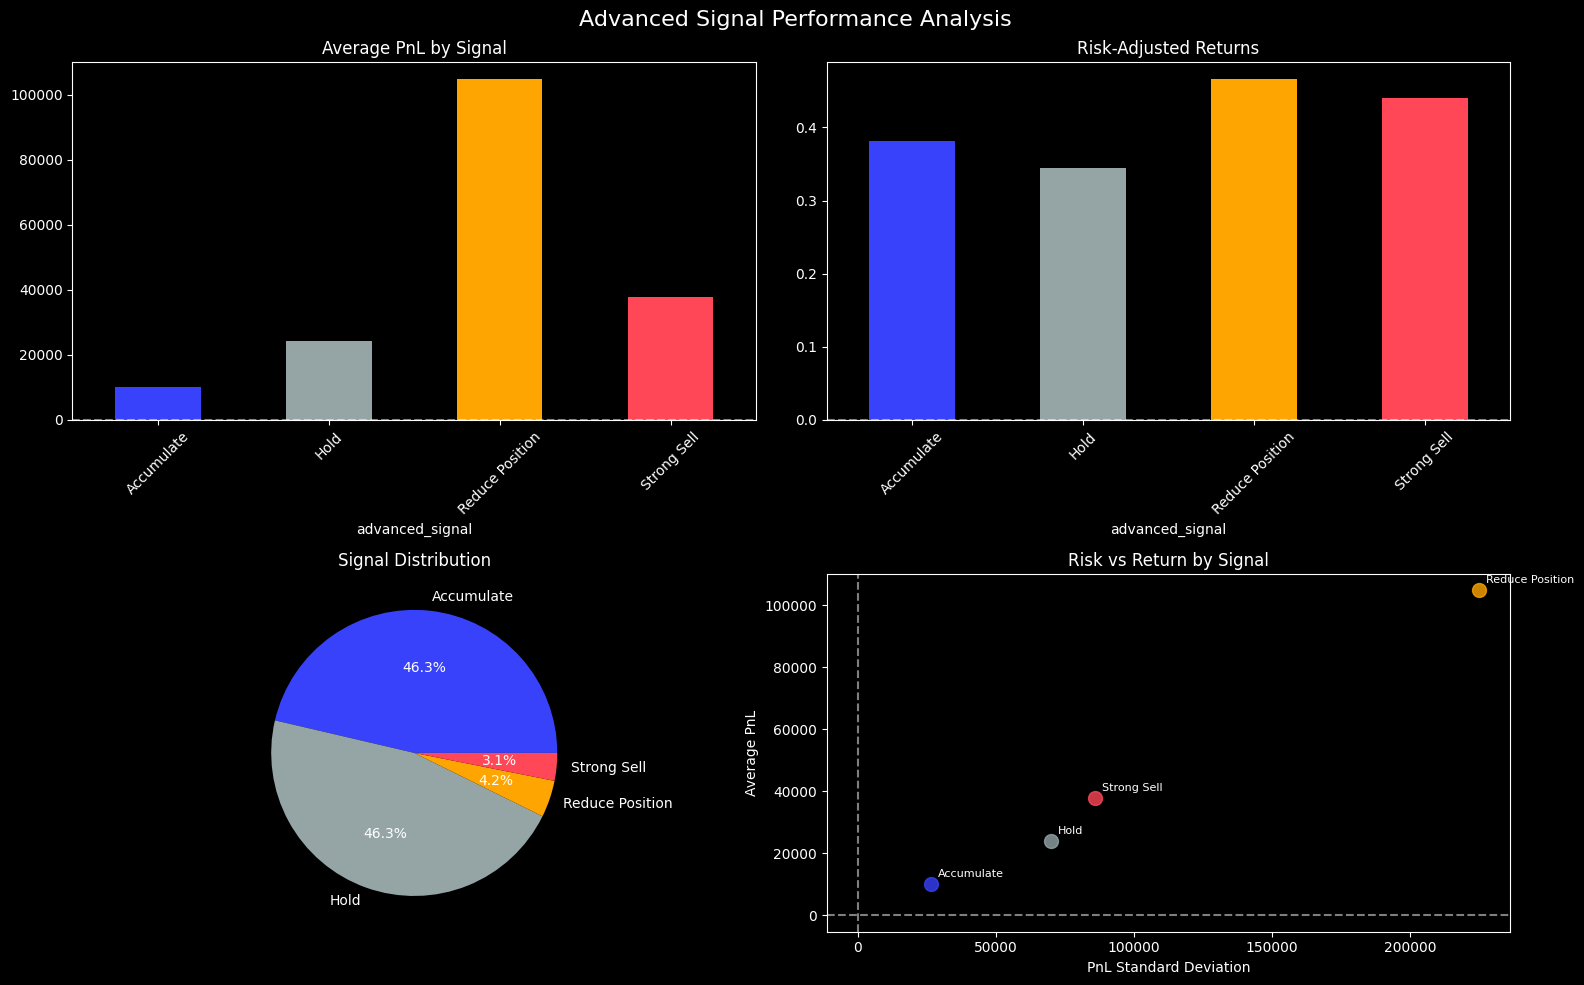


Best performing signal: Reduce Position
Risk-adjusted return: 0.466
Occurred 20 times


In [17]:
# Visualize advanced signal performance
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Advanced Signal Performance Analysis', fontsize=16, y=0.98)

signal_colors = {'Strong Buy': '#006400', 'Buy': '#2ed573', 'Accumulate': '#3742fa',
                'Hold': '#95a5a6', 'Reduce Position': '#ffa502', 'Strong Sell': '#ff4757'}

# Average PnL by signal
signal_performance['avg_pnl'].plot(kind='bar', ax=axes[0,0],
                                  color=[signal_colors.get(x, '#95a5a6') for x in signal_performance.index])
axes[0,0].set_title('Average PnL by Signal')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].axhline(y=0, color='white', linestyle='--', alpha=0.5)

# Risk-adjusted returns
signal_performance['risk_adjusted_return'].plot(kind='bar', ax=axes[0,1],
                                               color=[signal_colors.get(x, '#95a5a6') for x in signal_performance.index])
axes[0,1].set_title('Risk-Adjusted Returns')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].axhline(y=0, color='white', linestyle='--', alpha=0.5)

# Signal frequency pie chart
signal_performance['occurrences'].plot(kind='pie', ax=axes[1,0], autopct='%1.1f%%',
                                      colors=[signal_colors.get(x, '#95a5a6') for x in signal_performance.index])
axes[1,0].set_title('Signal Distribution')
axes[1,0].set_ylabel('')

# Risk vs return scatter
for i, signal in enumerate(signal_performance.index):
    axes[1,1].scatter(signal_performance['pnl_std'].iloc[i], 
                     signal_performance['avg_pnl'].iloc[i],
                     c=signal_colors.get(signal, '#95a5a6'), 
                     s=100, alpha=0.8, label=signal)
    axes[1,1].annotate(signal, 
                      (signal_performance['pnl_std'].iloc[i], signal_performance['avg_pnl'].iloc[i]),
                      xytext=(5, 5), textcoords='offset points', fontsize=8)

axes[1,1].set_title('Risk vs Return by Signal')
axes[1,1].set_xlabel('PnL Standard Deviation')
axes[1,1].set_ylabel('Average PnL')
axes[1,1].axhline(y=0, color='white', linestyle='--', alpha=0.5)
axes[1,1].axvline(x=0, color='white', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('outputs/advanced_signals_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Find best performing signal
best_signal = signal_performance['risk_adjusted_return'].idxmax()
best_performance = signal_performance.loc[best_signal, 'risk_adjusted_return']

print(f"\nBest performing signal: {best_signal}")
print(f"Risk-adjusted return: {best_performance:.3f}")
print(f"Occurred {signal_performance.loc[best_signal, 'occurrences']} times")

## Summary of Advanced Analytics

In [18]:

print("-" * 50)
print("Advanced Analytics Summary")
print("-" * 50)

print(f"\nMachine Learning Insights:")
print(f"PCA captured {pca.explained_variance_ratio_.sum():.1%} of data variance")
print(f"Most important feature: {feature_importance.index[0]}")
print(f"Risk regimes show {regime_persistence:.1%} persistence")

print(f"\nRisk Analysis:")
worst_var = risk_summary['VaR_95'].min()
worst_sentiment = risk_summary['VaR_95'].idxmin()
print(f"• Worst VaR (95%): ${worst_var:,.0f} during {worst_sentiment}")

highest_vol = risk_summary['Volatility'].max()
most_volatile = risk_summary['Volatility'].idxmax()
print(f"• Highest volatility: ${highest_vol:,.0f} during {most_volatile}")

print(f"\nSignal Performance:")
print(f"Best signal: {best_signal} (Risk-adj return: {best_performance:.2f})")
total_signals = signal_performance['occurrences'].sum()
active_signals = len(signal_performance[signal_performance.index != 'Hold'])
print(f"Active signals generated: {total_signals - signal_performance.loc['Hold', 'occurrences']} out of {total_signals} days")

print(f"\nKey Recommendations:")
print(f"Focus on {best_signal} strategy for optimal risk-adjusted returns")
print(f"Monitor {feature_importance.index[0]} as primary risk indicator")
print(f"Expect regime changes approximately {(1-regime_persistence)*100:.0f}% of the time")
print(f"Prepare for worst-case scenarios during {worst_sentiment} periods")

print("\n" + "-" * 50)
print("Advanced analysis complete")
print("-" * 50)

--------------------------------------------------
Advanced Analytics Summary
--------------------------------------------------

Machine Learning Insights:
PCA captured 54.9% of data variance
Most important feature: trader_efficiency
Risk regimes show 61.1% persistence

Risk Analysis:
• Worst VaR (95%): $-50,650 during Extreme Fear
• Highest volatility: $101,262 during Extreme Fear

Signal Performance:
Best signal: Reduce Position (Risk-adj return: 0.47)
Active signals generated: 257 out of 479 days

Key Recommendations:
Focus on Reduce Position strategy for optimal risk-adjusted returns
Monitor trader_efficiency as primary risk indicator
Expect regime changes approximately 39% of the time
Prepare for worst-case scenarios during Extreme Fear periods

--------------------------------------------------
Advanced analysis complete
--------------------------------------------------
